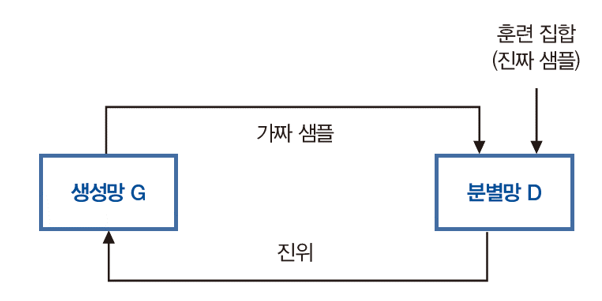

In [ ]:
# 생성망 G, 분별망 D라는 두개의 대립관계의 신경망을 사용
# G는 D를 속일 수 있을 정도로 품질이 높은 가짜 샘플생성
# D는 G가 만든 까짜 샘플을 높은 정확률로 맞힘

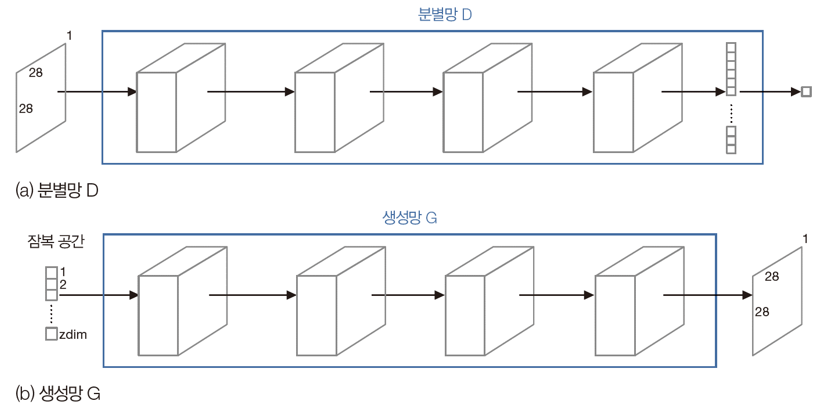

In [1]:
# mnist 데이터를 활용한 생성모델

In [2]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input,Dense,Flatten,Reshape,Conv2D, Conv2DTranspose,Dropout,BatchNormalization,UpSampling2D,Activation
from tensorflow.keras.models import Model
from tensorflow.keras import backend as k
from tensorflow.keras.losses import mse
import matplotlib.pyplot as plt

In [3]:
(x_train,y_train),(x_test,y_test) = mnist.load_data()
x_train = x_train/255.; x_test = x_test/255.
x_train.shape

11490434/11490434 [==============================] - 0s 0us/step


(60000, 28, 28)

In [6]:
x_train = np.expand_dims(x_train,axis=-1); x_test = np.expand_dims(x_test,axis=-1)

In [11]:
x_train.shape

(60000, 28, 28, 1)

In [7]:
batch_size = 64
epochs = 5000
dropout_rate = 0.4
batch_norm = 0.9
zdim = 100

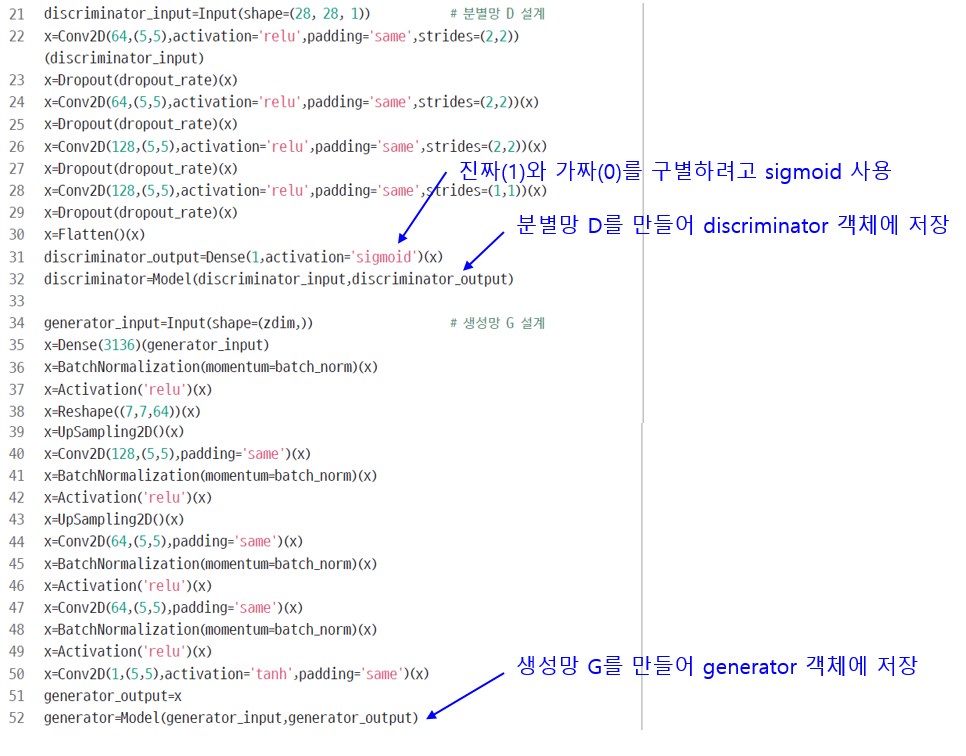

In [10]:
np.prod(x_train.shape[1:])

784

In [12]:
discriminator_input=Input(shape=x_train.shape[1:]) # 분별망 D 설계
x=Conv2D(64,(5,5),activation='relu',padding='same',strides=(2,2))(discriminator_input)
x=Dropout(dropout_rate)(x)
x=Conv2D(64,(5,5),activation='relu',padding='same',strides=(2,2))(x)
x=Dropout(dropout_rate)(x)
x=Conv2D(128,(5,5),activation='relu',padding='same',strides=(2,2))(x)
x=Dropout(dropout_rate)(x)
x=Conv2D(128,(5,5),activation='relu',padding='same',strides=(1,1))(x)
x=Dropout(dropout_rate)(x)
x=Flatten()(x)
discriminator_output=Dense(1,activation='sigmoid')(x)
discriminator=Model(discriminator_input,discriminator_output)

generator_input=Input(shape=(zdim,)) # 생성망 G 설계
x=Dense(3136)(generator_input)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Reshape((7,7,64))(x)
x=UpSampling2D()(x)
x=Conv2D(128,(5,5),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=UpSampling2D()(x)
x=Conv2D(64,(5,5),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Conv2D(64,(5,5),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Conv2D(1,(5,5),activation='tanh',padding='same')(x)
generator_output=x
generator=Model(generator_input,generator_output)

1/1 [==============================] - 0s 30ms/step


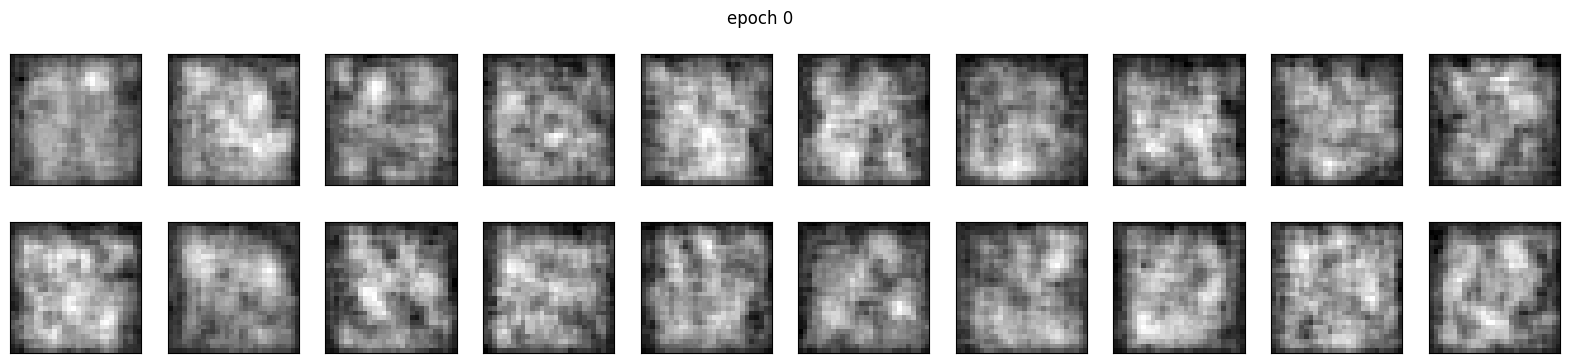

1/1 [==============================] - 0s 50ms/step


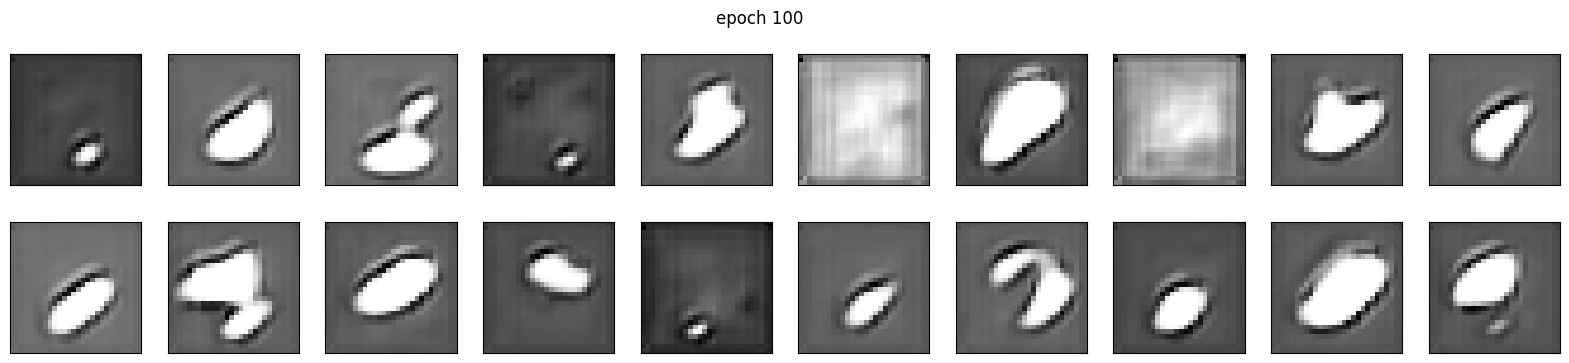

1/2 [==============>...............] - ETA: 0s

In [ ]:
discriminator.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

discriminator.trainable=False
gan_input=Input(shape=(zdim,))
gan_output=discriminator(generator(gan_input))
gan=Model(gan_input,gan_output)
gan.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

def train_discriminator(x_train):
    c=np.random.randint(0,x_train.shape[0],batch_size)
    real=x_train[c]
    discriminator.train_on_batch(real,np.ones((batch_size,1)))

    p=np.random.normal(0,1,(batch_size,zdim))
    fake=generator.predict(p)
    discriminator.train_on_batch(fake,np.zeros((batch_size,1)))

def train_generator():
    p=np.random.normal(0,1,(batch_size,zdim))
    gan.train_on_batch(p,np.ones((batch_size,1)))

for i in range(epochs+1): # 학습을 수행
    train_discriminator(x_train)
    train_generator()
    if(i%100==0): # 학습 도중 100세대마다 중간 상황 출력
        plt.figure(figsize=(20, 4))
        plt.suptitle('epoch '+str(i))
        for k in range(20):
            plt.subplot(2,10,k+1)
            img=generator.predict(np.random.normal(0,1,(1,zdim)))
            plt.imshow(img[0].reshape(28,28),cmap='gray')
            plt.xticks([]); plt.yticks([])
        plt.show()

imgs=generator.predict(np.random.normal(0,1,(50,zdim)))
plt.figure(figsize=(20,10)) # 학습을 마친 후 50개 샘플을 생성하여 출력
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.imshow(imgs[i].reshape(28,28),cmap='gray')
    plt.xticks([]); plt.yticks([])